# Metode EfficientNetB0

In [10]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)


2.7.0+cpu
0.22.0+cpu


Jumlah gambar training: 858
Jumlah gambar validation: 114
Jumlah gambar testing: 130
Kelas yang ada: ['Defect', 'Good-Quality']


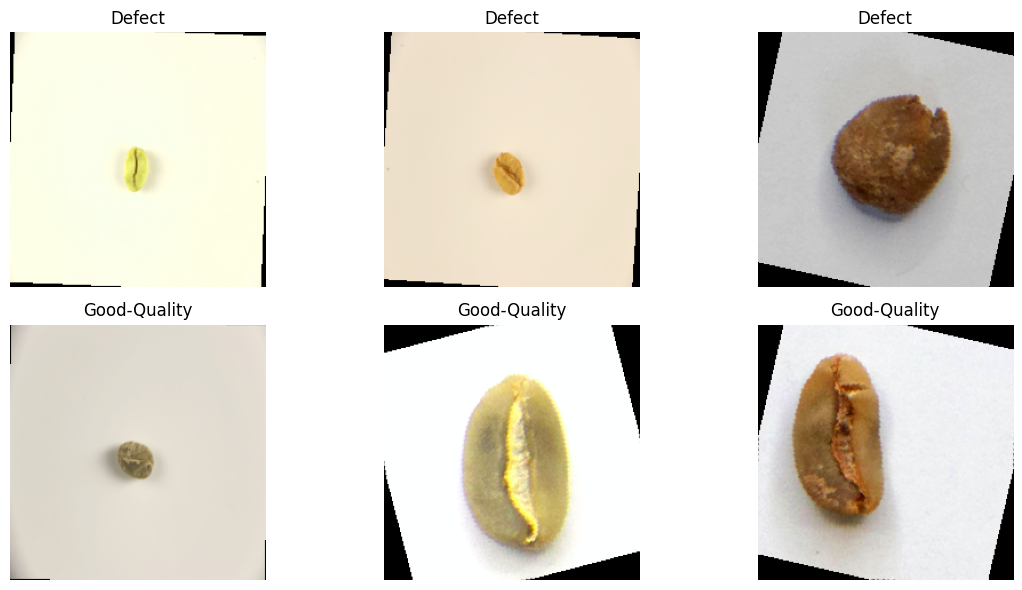

In [ ]:
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import random

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Transformasi dengan augmentasi untuk training
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    normalize
])

# Transformasi standar untuk validasi & testing
transform_val_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])

# Load dataset
train_dataset = datasets.ImageFolder(root=r'D:\SKRIPSI\Project\dataset-kopi-warga\training', transform=transform_train)
val_dataset = datasets.ImageFolder(root=r'D:\SKRIPSI\Project\dataset-kopi-warga\validation', transform=transform_val_test)
test_dataset = datasets.ImageFolder(root=r'D:\SKRIPSI\Project\dataset-kopi-warga\testing', transform=transform_val_test)

# Cek info dataset
print(f"Jumlah gambar training: {len(train_dataset)}")
print(f"Jumlah gambar validation: {len(val_dataset)}")
print(f"Jumlah gambar testing: {len(test_dataset)}")
print(f"Kelas yang ada: {train_dataset.classes}")

# Tampilkan contoh gambar training
fig, axs = plt.subplots(2, 3, figsize=(12, 6))
for ax in axs.flatten():
    idx = random.randint(0, len(train_dataset)-1)
    img, label = train_dataset[idx]
    img = img.permute(1, 2, 0).numpy()
    img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
    img = img.clip(0, 1)
    ax.imshow(img)
    ax.set_title(train_dataset.classes[label])
    ax.axis('off')
plt.tight_layout()
plt.show()


In [12]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Load dataset dengan transformasi yang sesuai
train_dataset = datasets.ImageFolder(root=r'D:\SKRIPSI\Project\dataset-kopi-warga\training', transform=transform_train)
val_dataset = datasets.ImageFolder(root=r'D:\SKRIPSI\Project\dataset-kopi-warga\validation', transform=transform_val_test)

# DataLoader dengan batch_size 32
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [13]:
# Setup Model EfficientNet-B0 untuk Klasifikasi
import torch
import torch.nn as nn
from torchvision import models

# Gunakan GPU jika tersedia
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model EfficientNet-B0 yang pre-trained dari ImageNet
model = models.efficientnet_b0(pretrained=True)

# Ubah output classifier agar sesuai jumlah kelas
num_classes = len(train_dataset.classes)
model.classifier[1] = nn.Linear(
    in_features=model.classifier[1].in_features,
    out_features=num_classes
)

# Pindahkan model ke device (GPU/CPU)
model = model.to(device)


In [14]:
#Tentukan Loss Function & Optimizer
import torch.nn as nn
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [15]:
# Training Model
from torch.optim.lr_scheduler import StepLR

num_epochs = 30

# Scheduler: turunkan learning rate setiap 10 epoch sebanyak 0.1x
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total

    model.eval()
    val_loss = 0.0 
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_acc = 100 * correct_val / total_val

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    # Update scheduler di akhir epoch
    scheduler.step()


Epoch 1/30, Train Loss: 0.3511, Train Acc: 82.05%, Val Loss: 0.7686, Val Acc: 75.44%
Epoch 2/30, Train Loss: 0.2506, Train Acc: 88.23%, Val Loss: 0.8124, Val Acc: 73.68%
Epoch 3/30, Train Loss: 0.1453, Train Acc: 94.64%, Val Loss: 0.1781, Val Acc: 89.47%
Epoch 4/30, Train Loss: 0.1167, Train Acc: 96.39%, Val Loss: 0.8570, Val Acc: 78.07%
Epoch 5/30, Train Loss: 0.1012, Train Acc: 96.50%, Val Loss: 0.2402, Val Acc: 92.11%
Epoch 6/30, Train Loss: 0.0590, Train Acc: 97.67%, Val Loss: 0.2147, Val Acc: 95.61%
Epoch 7/30, Train Loss: 0.0529, Train Acc: 98.14%, Val Loss: 0.9976, Val Acc: 80.70%
Epoch 8/30, Train Loss: 0.0954, Train Acc: 96.85%, Val Loss: 0.2463, Val Acc: 94.74%
Epoch 9/30, Train Loss: 0.0623, Train Acc: 97.32%, Val Loss: 0.4362, Val Acc: 85.09%
Epoch 10/30, Train Loss: 0.0899, Train Acc: 97.09%, Val Loss: 0.1114, Val Acc: 97.37%
Epoch 11/30, Train Loss: 0.0589, Train Acc: 97.90%, Val Loss: 0.1229, Val Acc: 95.61%
Epoch 12/30, Train Loss: 0.0491, Train Acc: 98.60%, Val Loss: 0

In [ ]:
#Save Model
torch.save(model.state_dict(), 'model_efficientNetB0_V-30.pth') 


In [1]:
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import torch.nn as nn
import os

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Path dataset dan model
test_dir = r"D:\SKRIPSI\Project\dataset-kopi-warga\testing"
model_path = "model_efficientNetB0_V-30.pth" 

# Transformasi untuk testing (sama seperti saat training/validasi)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load dataset testing
test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Load model EfficientNet-B0 dan sesuaikan dengan jumlah kelas
num_classes = len(test_dataset.classes)
class_names = test_dataset.classes

model = models.efficientnet_b0(pretrained=False)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

# Load bobot model
model.load_state_dict(torch.load(model_path, map_location=device))
model = model.to(device)
model.eval()

# Inisialisasi akurasi keseluruhan & per kelas
total = 0
correct = 0

class_correct = [0] * num_classes
class_total = [0] * num_classes

# Evaluasi model
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        for i in range(labels.size(0)):
            label = labels[i].item()
            pred = predicted[i].item()
            class_total[label] += 1
            if label == pred:
                class_correct[label] += 1

# Tampilkan akurasi keseluruhan
accuracy = 100 * correct / total
print(f"\n✅ Akurasi Keseluruhan pada Data Testing: {accuracy:.2f}%\n")

# Tampilkan akurasi per kelas
print("📊 Akurasi Per Kelas:")
for i in range(num_classes):
    if class_total[i] > 0:
        acc = 100 * class_correct[i] / class_total[i]
        print(f"- {class_names[i]}: {acc:.2f}% ({class_correct[i]}/{class_total[i]})")
    else:
        print(f"- {class_names[i]}: Tidak ada sampel")


c:\Users\Ghassan\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Ghassan\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)



✅ Akurasi Keseluruhan pada Data Testing: 96.92%

📊 Akurasi Per Kelas:
- Defect: 96.23% (51/53)
- Good-Quality: 97.40% (75/77)
